### This script should run in MOGP environment

In [2]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
sys.path.append('../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
import seaborn as sns
from evaluation import *
from GRM import *


def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-24 12:05:49.640963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 12:05:49.840990: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 12:05:49.893411: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 12:05:51.455552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #2
Using GPU #2


## Loading Dataset CITEseq_sampled
#### This dataset comprises 800 cells and 800 genes, subsampled from the main dataset.

In [3]:
file_path = os.path.join(data_folder_path, 'CITEseq', 'pbmc5k_citeseq_sampled.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
prot = mdata.mod['prot']

col_dict1 = {'CD14 mono': '#8000ff',
                 'memory-like NK': '#5641fd',
                 'CD8+ naïve T': '#2c7ef7',
                 'pDC': '#00b5eb',
                 'CD16 mono': '#2adddd',
                 'intermediate mono': '#54f6cb',
                 'CD4+ naïve T': '#80ffb4',
                 'mature B': '#abf69b',
                 'CD4+ memory T': '#d4dd80',
                 'NK': '#ffb360',
                 'CD8+ memory T': '#ff7e41',
                 'pre-B': '#ff4121',
                 'Treg': '#ff0000',
                 None: '#CDC9C9'}
#This list defines the assigned cell type based on the top marker genes in rank_genes_groups        
cell_type_list1=['CD4+ naïve T','CD4+ memory T','intermediate mono','CD8+ memory T','CD14 mono',
                   'NK','intermediate mono','mature B','pre-B','memory-like NK','intermediate mono', 
                   'CD16 mono','Treg','CD8+ naïve T','pDC']
cell_type_list_modified1=cell_type_list1
rank_genes_groups=rna.uns["rank_genes_groups"]["names"]

#This list defines the assigned cell type based on the top marker prots in rank_prots_groups
cell_type_list2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
               'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
rank_prots_groups=prot.uns["rank_genes_groups"]["names"]
cell_type_list_modified2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
                 'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
     

In [4]:
rna

AnnData object with n_obs × n_vars = 800 × 800
    obs: 'celltype'
    uns: 'rank_genes_groups'

In [5]:
prot

AnnData object with n_obs × n_vars = 800 × 32
    obs: 'celltype'
    uns: 'rank_genes_groups'

In [6]:
# We normalize the data before running the experiments to ensure consistency and accuracy in the results. 
matrix1 = rna.X
matrix2 = prot.X
RNA_Normalized_2000 = (matrix1-np.mean(matrix1,0))/np.std(matrix1,0)

prot_Normalized_2000 = (matrix2-np.mean(matrix2,0))/np.std(matrix2,0)

In [7]:
[cells,genes] = RNA_Normalized_2000.shape

In [8]:
# I: number of cells
# J: number of genes
# K: number of proteins
np.random.seed(11111986)
[I,J] = RNA_Normalized_2000.shape
[I,K] = prot_Normalized_2000.shape

In [9]:
# All row and column indices of RNA_Normalized_2000 are stored in X_tr1, while the corresponding values are saved in Y_tr1.
[i,j] = np.nonzero(RNA_Normalized_2000)
X_tr1 = []
for cnt in range(len(i)):
    X_tr1.append([i[cnt],j[cnt]])
X_tr1 = np.asarray(X_tr1)
Y_tr1 = RNA_Normalized_2000.ravel()
 

In [10]:
# All row and column indices of prot_Normalized_2000 are stored in X_tr2, while the corresponding values are saved in Y_tr2.
[i,j] = np.nonzero(prot_Normalized_2000)
X_tr2 = []
for cnt in range(len(i)):
    X_tr2.append([i[cnt],j[cnt]])
X_tr2 = np.asarray(X_tr2)
Y_tr2 = prot_Normalized_2000.ravel()
 

## Running
#### By adjusting the values of the latent dimensions for both cell and gene embeddings, as well as the number of epochs, inducing points and batch sizes, we generate embeddings using MOGP. ¶

In [10]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 200
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 10000
# We can initialize the model with the output of PCA or PPCA and apply some scaling to our method.
# However, in all experiments, these four parameters are set to 0.
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = float(0.001)
lr = float(0.01)
kernel = ["RBF"]

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 35.3124 - gp_layer_2_prior_kl: 1.7068e-05
Epoch 1: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 19s 263ms/step - loss: 35.3124 - gp_layer_2_prior_kl: 1.7068e-05
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 23.0397 - gp_layer_2_prior_kl: 1.0035e-04
Epoch 2: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 263ms/step - loss: 23.0397 - gp_layer_2_prior_kl: 1.0035e-04
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 17.0844 - gp_layer_2_prior_kl: 1.3989e-04
Epoch 3: saving mod

Epoch 20/200
64/64 [==============================] - ETA: 0s - loss: 9.1451 - gp_layer_2_prior_kl: 7.2185e-04
Epoch 20: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 266ms/step - loss: 9.1451 - gp_layer_2_prior_kl: 7.2185e-04
Epoch 21/200
64/64 [==============================] - ETA: 0s - loss: 8.9292 - gp_layer_2_prior_kl: 7.7448e-04
Epoch 21: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 268ms/step - loss: 8.9292 - gp_layer_2_prior_kl: 7.7448e-04
Epoch 22/200
64/64 [==============================] - ETA: 0s - loss: 8.7400 - gp_layer_2_prior_kl: 8.0635e-04
Epoch 22: saving mo

Epoch 39/200
64/64 [==============================] - ETA: 0s - loss: 6.7648 - gp_layer_2_prior_kl: 0.0010
Epoch 39: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 270ms/step - loss: 6.7648 - gp_layer_2_prior_kl: 0.0010
Epoch 40/200
64/64 [==============================] - ETA: 0s - loss: 6.6936 - gp_layer_2_prior_kl: 0.0010
Epoch 40: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 265ms/step - loss: 6.6936 - gp_layer_2_prior_kl: 0.0010
Epoch 41/200
64/64 [==============================] - ETA: 0s - loss: 6.6255 - gp_layer_2_prior_kl: 0.0010
Epoch 41: saving model to ./RunningPBMC

64/64 [==============================] - ETA: 0s - loss: 5.5772 - gp_layer_2_prior_kl: 0.0013
Epoch 77: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 266ms/step - loss: 5.5772 - gp_layer_2_prior_kl: 0.0013
Epoch 78/200
64/64 [==============================] - ETA: 0s - loss: 5.5684 - gp_layer_2_prior_kl: 0.0013
Epoch 78: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 265ms/step - loss: 5.5684 - gp_layer_2_prior_kl: 0.0013
Epoch 79/200
64/64 [==============================] - ETA: 0s - loss: 5.5608 - gp_layer_2_prior_kl: 0.0013
Epoch 79: saving model to ./RunningPBMC5KCITEseqRNA-

64/64 [==============================] - ETA: 0s - loss: 5.4104 - gp_layer_2_prior_kl: 0.0020
Epoch 115: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 266ms/step - loss: 5.4104 - gp_layer_2_prior_kl: 0.0020
Epoch 116/200
64/64 [==============================] - ETA: 0s - loss: 5.4097 - gp_layer_2_prior_kl: 0.0020
Epoch 116: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 266ms/step - loss: 5.4097 - gp_layer_2_prior_kl: 0.0020
Epoch 117/200
64/64 [==============================] - ETA: 0s - loss: 5.4087 - gp_layer_2_prior_kl: 0.0020
Epoch 117: saving model to ./RunningPBMC5KCITEse

64/64 [==============================] - ETA: 0s - loss: 5.3684 - gp_layer_2_prior_kl: 0.0029
Epoch 153: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 265ms/step - loss: 5.3684 - gp_layer_2_prior_kl: 0.0029
Epoch 154/200
64/64 [==============================] - ETA: 0s - loss: 5.3680 - gp_layer_2_prior_kl: 0.0029
Epoch 154: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 265ms/step - loss: 5.3680 - gp_layer_2_prior_kl: 0.0029
Epoch 155/200
64/64 [==============================] - ETA: 0s - loss: 5.3676 - gp_layer_2_prior_kl: 0.0029
Epoch 155: saving model to ./RunningPBMC5KCITEse

64/64 [==============================] - ETA: 0s - loss: 5.3594 - gp_layer_2_prior_kl: 0.0030
Epoch 191: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 266ms/step - loss: 5.3594 - gp_layer_2_prior_kl: 0.0030
Epoch 192/200
64/64 [==============================] - ETA: 0s - loss: 5.3595 - gp_layer_2_prior_kl: 0.0030
Epoch 192: saving model to ./RunningPBMC5KCITEseqRNA-GPFlux cells=800  genes=800  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=200  emb_reg=0.001 with_PCA=0/model_params.ckpt
64/64 [==============================] - 17s 266ms/step - loss: 5.3595 - gp_layer_2_prior_kl: 0.0030
Epoch 193/200
64/64 [==============================] - ETA: 0s - loss: 5.3597 - gp_layer_2_prior_kl: 0.0031
Epoch 193: saving model to ./RunningPBMC5KCITEse

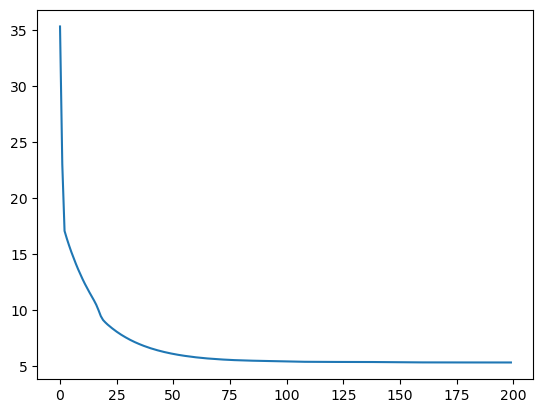

In [16]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/' 
hyper_params = {
'I':I,
'J':J,
'K':None,    # the number of entities in each domain
'M1': n_inducing_points1,                  # the number of inducing pairs
'M2': n_inducing_points2,                  # the number of inducing pairs
'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
'batch_size':batch_size,      # the size of training batches
'obs_mean1': Y_tr1.mean(),  # the mean of target
'obs_mean2': Y_tr2.mean(),  # the mean of target
'emb_reg': emb_reg,          # l2 norm on the embeddings
'lr': lr,                # the learning rate 
'save_path': save_path,        # path to save the trained models.
}  

gp_md = GPD(**hyper_params)
if with_PCA == 0:
    gp_md.build(kernels=kernel)

hist= gp_md.train((X_tr1+1).astype(int), Y_tr1, X_tr2=(X_tr2+1).astype(int), Y_tr2=Y_tr2, n_iter=num_epochs)


## Evaluation
#### After running MOGP, the results are provided and the embedded cells and genes are visualized. In the cell embedding, all data points are colored by cell type. In the gene embedding, all marker genes for each cell type are colored according to their relevance to the cell type. The number of marker genes for each cell type is 100.

2024-06-23 17:03:30.296618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 17:03:31.036960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12544 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/la

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


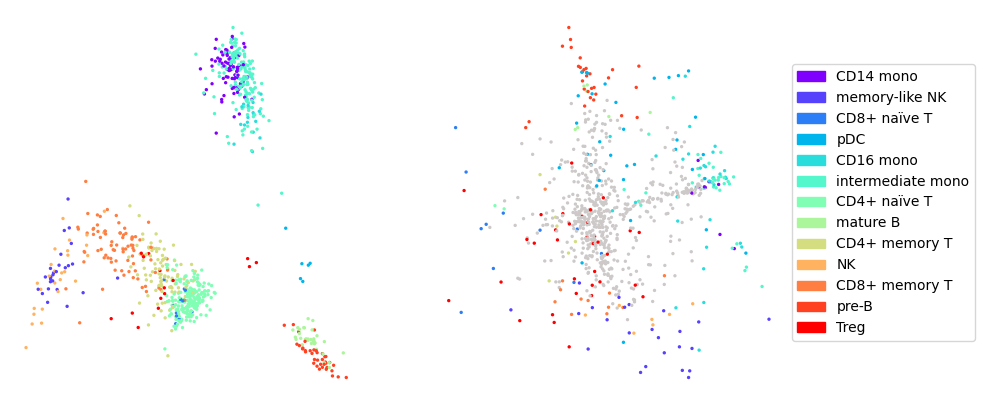

In [11]:
if (with_PCA==0 or with_PPCA==0):
    title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
    save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/' 
    hyper_params = {
    'I':I,
    'J':J,
    'K':None,    # the number of entities in each domain
    'M1': n_inducing_points1,                  # the number of inducing pairs
    'M2': n_inducing_points2,                  # the number of inducing pairs
    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
    'batch_size':batch_size,      # the size of training batches
    'obs_mean1': Y_tr1.mean(),  # the mean of target
    'obs_mean2': None,  # the mean of target
    'emb_reg': emb_reg,          # l2 norm on the embeddings
    'lr': lr,                # the learning rate 
    'save_path': save_path,        # path to save the trained models.
    }  
    
    gp_md = GPD(**hyper_params)
    gp_md.build(kernels=kernel)
    gp_md.load_model((X_tr1+1), None)
    
    emb1 = gp_md.emb1
    embs1 = emb1((X_tr1+1)[0:-1:J,0])
    
    emb2 = gp_md.emb2
    embs2 = emb2((X_tr1+1)[0:J,1])
    
    RNA_struct_MOGP = ad.AnnData(embs1.numpy())
    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
    
    Genes_struct_MOGP = ad.AnnData(embs2.numpy())
    Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
    
    Relating_clusters_of_emb1_to_clusters_of_emb2_CITEseq(rna, None, RNA_struct_MOGP, Genes_struct_MOGP, Prot_struct_MOGP=None, col_dict1=col_dict1, cell_type_list_modified1=cell_type_list_modified1, cell_type_list_modified2=cell_type_list_modified2, n_cell_types=len(list(set(rna.obs["celltype"]))),n_marker_genes=100, use_umap=False)
    

#### We save the cell and gene embeddings for further analysis in the Running_GeneRelevanceMAP.ipynb file.

In [12]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/embs1.csv' 
file = open(save_path,'wb')
pickle.dump(embs1.numpy(),file)
file.close()

title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/embs2.csv' 
file = open(save_path,'wb')
pickle.dump(embs2.numpy(),file)
file.close()